In [57]:
%load_ext autoreload
%autoreload 2

import subprocess
from pathlib import Path
import numpy as np
import ruamel.yaml as yaml
import torch
from easydict import EasyDict as edict
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import trange

from ex2mcmc.gan_distribution import Distribution, DistributionRegistry
from ex2mcmc.models.rnvp_minimal import RealNVPProposal
from ex2mcmc.models.utils import GANWrapper
from ex2mcmc.utils.general_utils import DotConfig, PROJECT_PATH, LOG_DIR, IMGS_DIR

from experiments.exp_cifar10_fid.run import define_sampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
args = edict()

method = 'flex2mcmc'

configs = [f'configs/mcmc_configs/{method}.yml', 'configs/mmc_sngan.yml']
configs = [Path(PROJECT_PATH, x).as_posix() for x in configs]
args.configs = configs

proc = subprocess.Popen("/bin/bash", stdin=subprocess.PIPE, stdout=subprocess.PIPE)
out, err = proc.communicate(
        ("cat - " + " ".join([f"{conf} <(echo)" for conf in args.configs])).encode(
            "utf-8"
        )
    )
config = yaml.round_trip_load(out.decode("utf-8"))
config = DotConfig(config)

In [52]:
config.sample_params['total_n'] = 4
config.sample_params['batch_size'] = 4
config.sample_params.params['n_steps'] = 13
config.sample_params.params['save_every'] = 1

In [53]:
device = torch.device(config.device if torch.cuda.is_available() else "cpu")

gan = GANWrapper(config.gan_config, device)
ref_dist = DistributionRegistry.create(
    config.sample_params.distribution.name, gan=gan
)

Transform: Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


In [54]:
save_dir = Path('log', 'tutorial')
save_dir.mkdir(exist_ok=True, parents=True)

sampler = define_sampler(config, gan, ref_dist, save_dir)

In [55]:
start_latents = gan.prior.sample((config.sample_params.total_n,)).cpu()
start_step_id = 0
labels = torch.LongTensor(
    np.random.randint(
        0,
        9, #dataset_info.get("n_classes", 10) - 1,
        config.sample_params.total_n,
    )
)

In [80]:
if config.get("flow", None):
    gan.gen.proposal = RealNVPProposal(gan.gen.z_dim, device=device)
    opt = torch.optim.Adam(gan.gen.proposal.parameters(), 1e-3)
    for _ in trange(100):
        e = -gan.gen.proposal.log_prob(
            gan.gen.prior.sample((config.batch_size,))
        ).mean()
        gan.gen.proposal.zero_grad()
        e.backward()
        opt.step()
    opt = torch.optim.Adam(
        gan.gen.proposal.parameters(), **config.flow.opt_params
    )
    gan.gen.proposal.optim = opt
    gan.gen.proposal.train()
    gan.gen.proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
        opt, lambda it: int(it < config.flow.train_iters)
    )
else:
    gan.gen.proposal = gan.gen.prior

start = start_latents.to(device)
label = labels.to(device)
gan.set_label(label)

zs, xs = sampler(start)
sampler.reset()
gan.gen.input = gan.gen.output = gan.dis.input = gan.dis.output = None

zs = torch.stack(zs, 0).cpu()
xs = torch.stack(xs, 0).cpu()
print(zs.shape)


  8%|▊         | 1/13 [00:15<03:06, 15.51s/it]

KL forw 180.226,                     KL back 1.059 


 15%|█▌        | 2/13 [00:23<02:04, 11.31s/it]

KL forw 180.626,                     KL back 1.152 
KL forw 179.858,                     KL back 1.265 


 23%|██▎       | 3/13 [00:39<02:11, 13.11s/it]

KL forw 178.752,                     KL back 1.988 


 38%|███▊      | 5/13 [01:10<01:57, 14.66s/it]

KL forw 181.847,                     KL back 1.501 
KL forw 181.784,                     KL back 2.016 


 46%|████▌     | 6/13 [01:25<01:44, 14.97s/it]

KL forw 180.015,                     KL back 1.917 


 54%|█████▍    | 7/13 [01:43<01:33, 15.65s/it]

KL forw 178.891,                     KL back 2.066 


 62%|██████▏   | 8/13 [01:58<01:17, 15.53s/it]

KL forw 176.971,                     KL back 1.848 


 77%|███████▋  | 10/13 [02:28<00:46, 15.38s/it]

KL forw 174.326,                     KL back 2.868 
KL forw 176.546,                     KL back 2.904 


 85%|████████▍ | 11/13 [02:44<00:31, 15.58s/it]

KL forw 176.139,                     KL back 3.460 


100%|██████████| 13/13 [03:16<00:00, 15.10s/it]

KL forw 181.132,                     KL back 3.363 
Time elapsed:  196.66s
torch.Size([14, 4, 128])


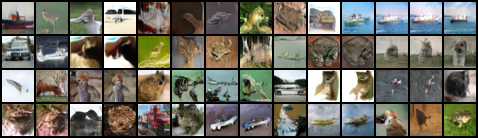

In [81]:
imgs = []
for step in range(xs.shape[0]):
    img = xs[step]
    imgs.append(img)
imgs = torch.stack(imgs, 1).view(-1, 3, 32, 32)
grid = make_grid(imgs, nrow=xs.shape[0])

grid = (255 * grid.permute(1, 2, 0).numpy()).astype('uint8')
Image.fromarray(grid)